<a href="https://colab.research.google.com/github/NotAbdelrahmanelsayed/sentiment_crypto_forcasting/blob/main/Modeling_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/NotAbdelrahmanelsayed/sentiment_crypto_forcasting.git
%mv  /content/sentiment_crypto_forcasting/data  /content/data
%mv  /content/sentiment_crypto_forcasting/modeling.py  /content/modeling.py
%mv  /content/sentiment_crypto_forcasting/figures.py  /content/figures.py
%mv  /content/sentiment_crypto_forcasting/report.py  /content/report.py

Cloning into 'sentiment_crypto_forcasting'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 83 (delta 40), reused 58 (delta 20), pack-reused 0 (from 0)
Receiving objects: 100% (83/83), 862.08 KiB | 15.96 MiB/s, done.
Resolving deltas: 100% (40/40), done.


#####Import Dependencies


In [2]:
!pip install reportlab shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 47.4 MB/s eta 0:00:00


In [3]:
%matplotlib inline
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages


In [4]:
config = {
    "sentiment_data_path": "/content/data/sentiments_2025.csv",
    "coins_data_directory": "/content/data/coins_data",
}
directory = config['coins_data_directory']
csv_files_list = []

for file_name in os.listdir(directory):
  if file_name.endswith('.csv'):
    file_path = os.path.join(directory, file_name)
    csv_files_list.append(file_path)


In [5]:
categories = {
    "Fiat Collateralized": ['USDT_usd_history', 'USDC_usd_history'],
    "Crypto-Collateralized": ['DAI_usd_history'],
    "Algorithmic Stablecoins": ['AMPL_usd_history'],
    "Commodity-backed stablecoins": ['PAXG_usd_history'],
    "Bitcoin and ETH": ['BTC_usd_history', 'ETH_usd_history']
}


def define_categories_path(folder_path):
  """Function to define a path for each coins category to save the analysis's pdf"""
  os.makedirs(folder_path, exist_ok=True)
  paths = []
  for category in categories:
    coin_path = os.path.join(folder_path, category + '.pdf')
    paths.append(coin_path)
  return paths

path = '/content/drive/MyDrive/news_impact/2025-3/results/'
pdfs_paths = define_categories_path(path)
config['pdfs_paths'] = {category: pdfs_paths[i] for i, category in enumerate(categories)}

In [6]:
def read_coin_data(coin_folder):
    coin_data = []
    for file in os.listdir(coin_folder):
        if file.endswith('.csv'):
            file_path = os.path.join(coin_folder, file)
            df = pd.read_csv(file_path)
            df['Symbol'] = file.split('.')[0]
            coin_data.append(df)
    return pd.concat(coin_data, ignore_index=True)
coin_data = read_coin_data(directory)

In [7]:
sentiment_data = pd.read_csv(config['sentiment_data_path'])

In [21]:
def prepare_data(coin_df, sentiment_df):
    coin_df = coin_df.copy()
    sentiment_df = sentiment_df.copy()

    # Ensure 'date' column is in datetime format
    coin_df['date'] = pd.to_datetime(coin_df['date'])
    sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

    # Merge the dataframes on 'date'
    merged_df = pd.merge(coin_df, sentiment_df, on='date', how='inner')

    # Create features before removing columns
    merged_df['open_pct_change'] = merged_df.groupby('Symbol')['OPEN'].pct_change()

    # Group by coin symbol and process each time series separately
    merged_df = merged_df.groupby('Symbol').apply(
        lambda x: x.sort_values('date').assign(
            target=lambda df: df['CLOSE'].shift(-1),
            shifted_volume=lambda df: df['VOLUME'].shift(-1)
        )
    ).reset_index(drop=True)

    # Multi-class target classification
    merged_df["target_class"] = 0  # Default: Minor Change
    merged_df.loc[merged_df['shifted_volume'] >= merged_df["VOLUME"] * 1.10, "target_class"] = 2  # High Increase
    merged_df.loc[merged_df['shifted_volume'] <= merged_df["VOLUME"] * 0.90, "target_class"] = 1  # High Decrease

    # Remove leakage columns
    cols_to_drop = ['VOLUME', 'next_volume', 'volume_change', 'OPEN', 'CLOSE']
    merged_df = merged_df.drop(columns=cols_to_drop, errors="ignore")

    # Keep only proportion features from sentiment
    keep_cols = [col for col in merged_df.columns if '_prop' in col] + \
                ['date', 'Symbol', 'HIGH', 'LOW', 'target', 'target_class', 'open_pct_change']

    return merged_df[keep_cols].dropna()

<ipython-input-21-0fefcc93f4b8>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_df = merged_df.groupby('Symbol').apply(


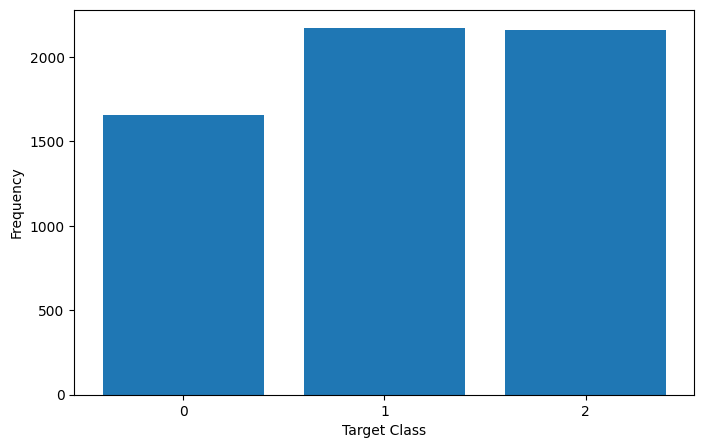

In [22]:
# Get the counts of each class
class_counts = prepare_data(coin_data, sentiment_data)["target_class"].value_counts()

# Plot as a bar chart
plt.figure(figsize=(8, 5))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel("Target Class")
plt.ylabel("Frequency")
plt.xticks([0, 1, 2])
plt.show()


### Regression Model and Helper Functions


### Classification Model and Helper Functions


In [24]:
from modeling import (train_classification_model,
                      evaluate_classification_model,
                      tune_classification_model,
                      train_regression_model,
                      tune_regression_model,
                      evaluate_regression_model,

                      )
from figures import (visualize_classification_model,
                     save_fig_as_image,
                     visualize_feature_importance,
                     visualize_regression_model,
                     visualize_residuals,
                     explain_model,
                     visualize_residual_analysis,
                     )

###Additional visualizations

#### AI GENERATED CODE: FOR REPORT GENERATION

In [25]:
from report import (create_metrics_figure,
                    create_metrics_table,
                    add_elements_to_pdf)

##Run and Save Analysis Results


In [26]:
def analyze_coin(coin_data, sentiment_data, coin_name, pdfpages, results_df):
    merged_df = prepare_data(coin_data, sentiment_data)
    X = merged_df.drop(columns=['Symbol', 'date', 'CLOSE', 'target', 'target_class', 'HIGH', 'LOW', 'VOLUME'], errors="ignore")
    feature_names = X.columns
    y_reg = merged_df['target']
    y_class = merged_df['target_class']

    split_idx = int(0.8 * len(X))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train_reg, y_test_reg = y_reg.iloc[:split_idx], y_reg.iloc[split_idx:]
    y_train_class, y_test_class = y_class.iloc[:split_idx], y_class.iloc[split_idx:]

    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    y_train_reg = y_train_reg.astype(np.float32)
    y_test_reg = y_test_reg.astype(np.float32)

    X_train = np.ascontiguousarray(X_train)
    X_test = np.ascontiguousarray(X_test)


    # Regression task
    regression_model, reg_params = tune_regression_model(X_train, y_train_reg)
    mse, rmse, r2 = evaluate_regression_model(regression_model, X_test, y_test_reg)
    regression_metrics = {'MSE': mse, 'RMSE': rmse, 'R^2': r2}

    print(f"\nRegression Model Performance for {coin_name}: MSE = {mse}, RMSE = {rmse}, R^2 = {r2}")

    # Classification task
    classification_model, clf_params = tune_classification_model(X_train, y_train_class)
    accuracy, precision, recall, f1 = evaluate_classification_model(classification_model, X_test, y_test_class)
    classification_metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1}

    # Saving the results in one DataFrame
    combined_metrics = classification_metrics.copy()
    combined_metrics.update(regression_metrics)
    combined_metrics['coin_name'] = coin_name
    metrics_df = pd.DataFrame([combined_metrics])
    updated_results_df = pd.concat([results_df, metrics_df], ignore_index=True)


    figures = [
        visualize_regression_model(y_test_reg, regression_model.predict(X_test), coin_name),
        visualize_feature_importance(regression_model, feature_names, coin_name),
        visualize_classification_model(classification_model, X_test, y_test_class, coin_name),
        visualize_feature_importance(classification_model, feature_names, coin_name),
        create_metrics_figure(regression_metrics, f'Regression Metrics for {coin_name}', reg_params),
        create_metrics_figure(classification_metrics, f'Classification Metrics for {coin_name}', clf_params),
        visualize_residual_analysis(y_test_reg, regression_model.predict(X_test), dates_test),
        explain_model(regression_model, X_train, features, coin_name),
            ]


    for fig in figures:
        pdfpages.savefig(fig)
        plt.close(fig)
    return updated_results_df

<ipython-input-21-0fefcc93f4b8>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_df = merged_df.groupby('Symbol').apply(



Regression Model Performance for BTC_usd_history: MSE = 38605260.0, RMSE = 6213.313125861275, R^2 = -0.7299321889877319


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


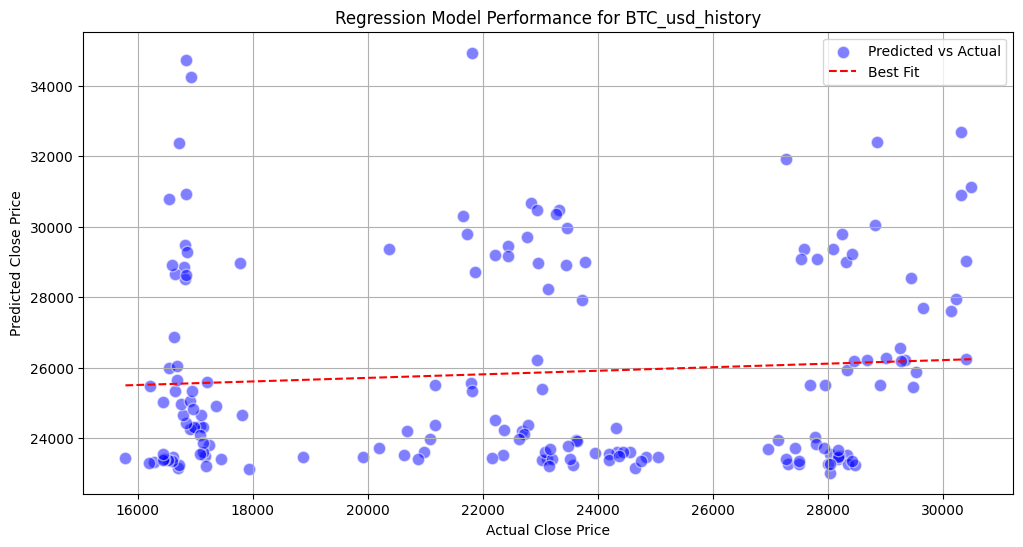

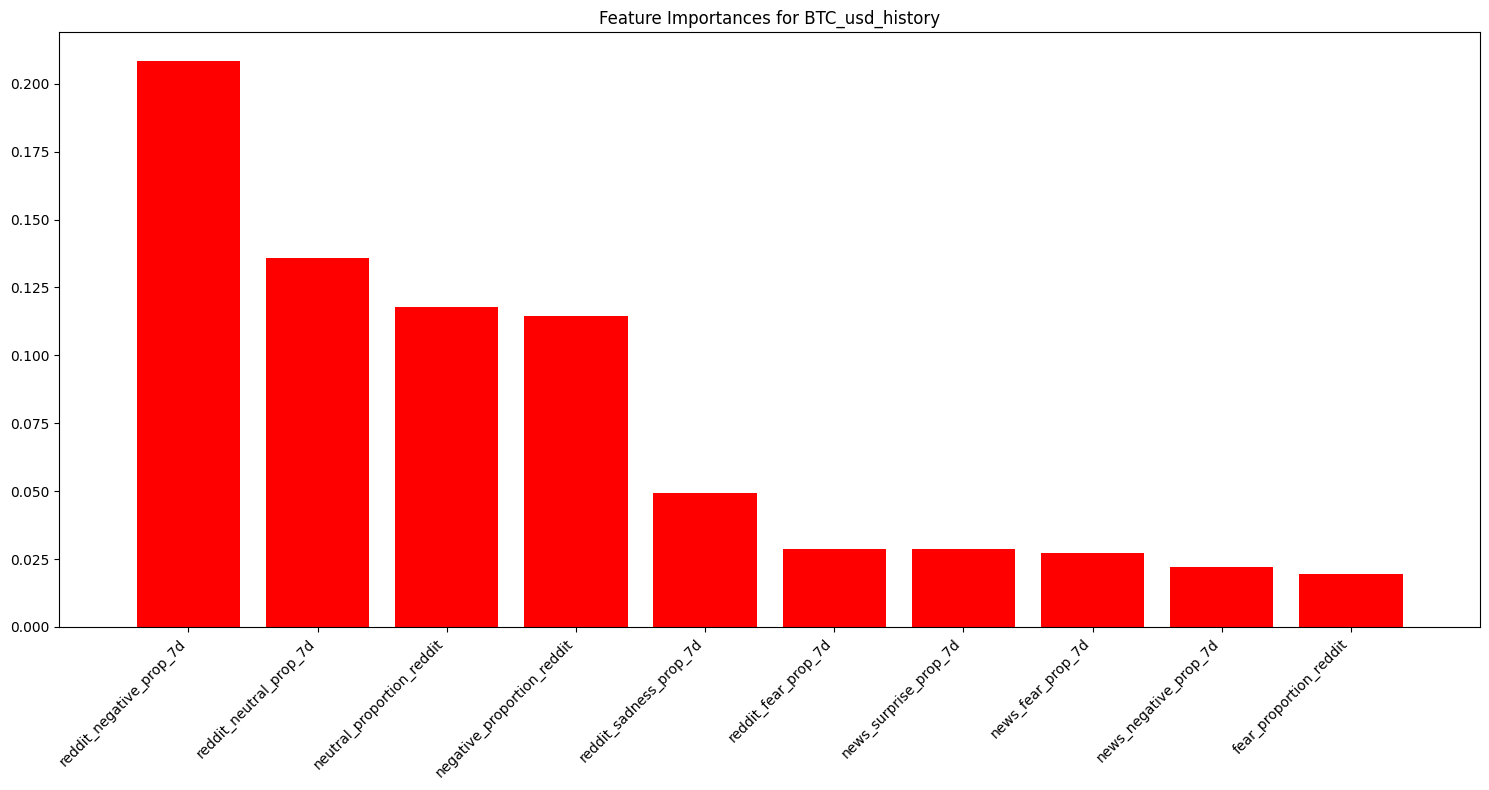

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Model Performance for BTC_usd_history:
Accuracy: 0.5058, Precision: 0.3914, Recall: 0.5058, F1-Score: 0.4388


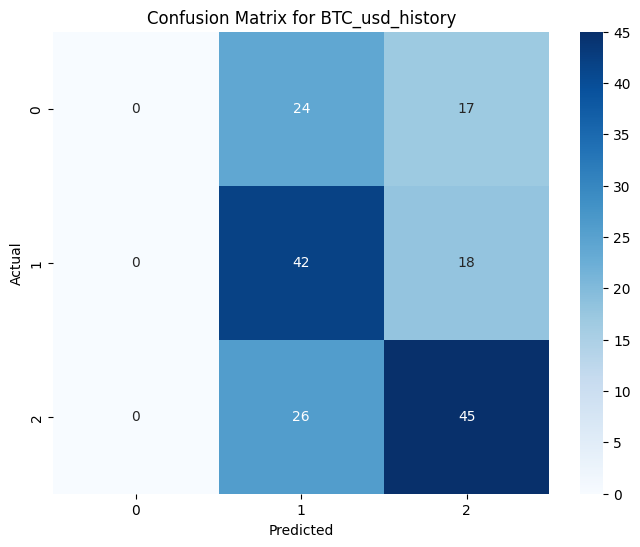

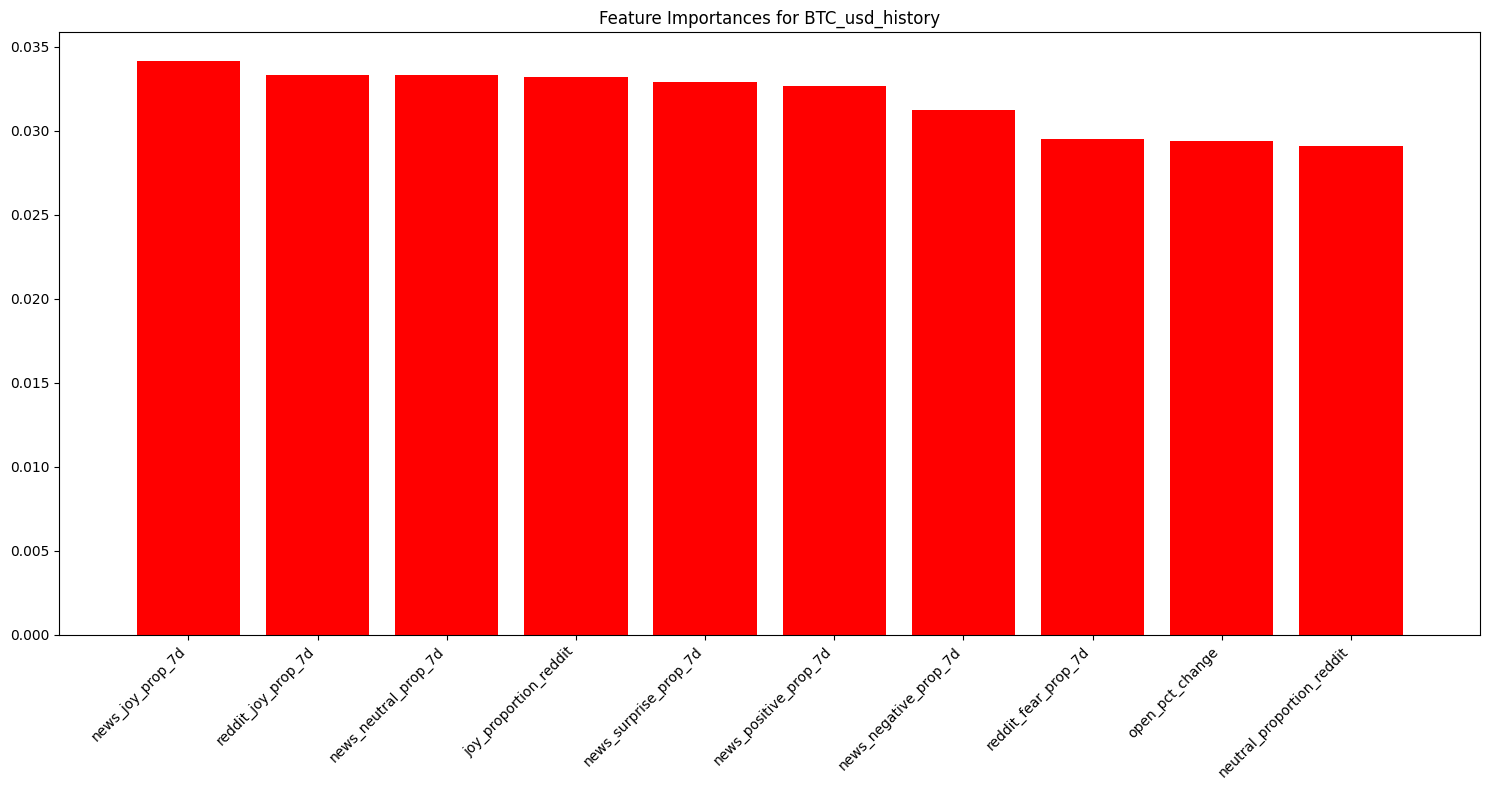

NameError: name 'dates_test' is not defined

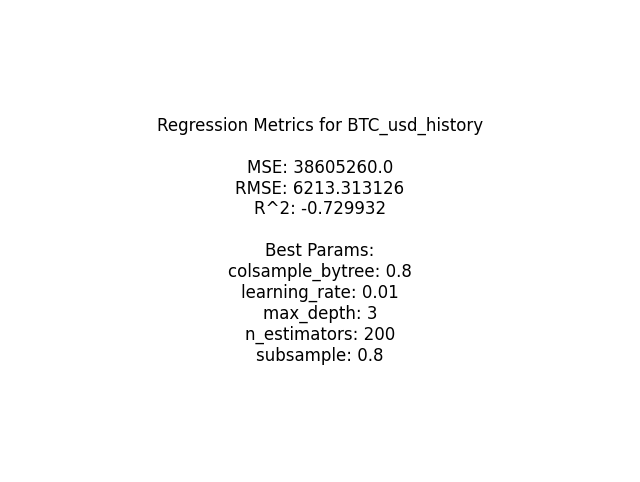

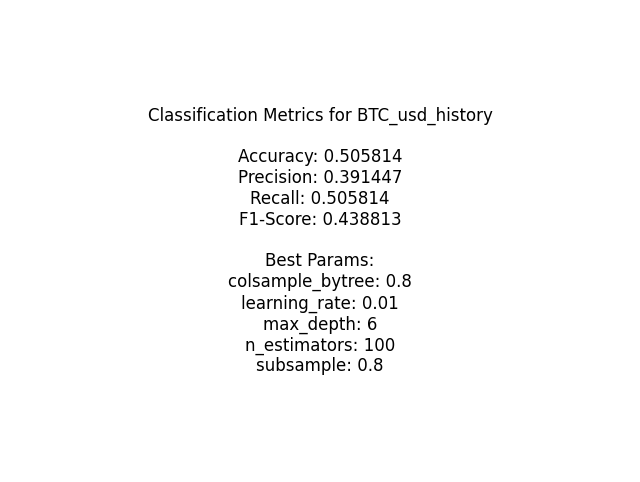

In [27]:
results_df = pd.DataFrame()
pdf_paths = config['pdfs_paths']
for category, pdf_path in pdf_paths.items():
  coin_symbols = categories[category]
  with PdfPages(pdf_path) as pdf_pages:
    for coin_symbol in coin_symbols:
      if coin_symbol == "BTC_usd_history":
        coin_data_filtered = coin_data[coin_data['Symbol'] == coin_symbol]
        results_df = analyze_coin(coin_data_filtered, sentiment_data, coin_symbol, pdf_pages, results_df)

In [ ]:
# results_df.to_csv(os.path.join(path, 'results_df_2024.csv'), index=False)

In [ ]:
# results_df_2024 = results_df
# result_df_older = pd.read_csv(os.path.join(path, 'results_df.csv'))

In [ ]:
# results_df_2024.compare(result_df_older, True, True, result_names=("older", "2024"))